###Problema:
Para una barra de cierto material, localizado en el intervalo $[−1,1]$, supongamos que $u(x)$ es una función que representa la temperatura relativa (con respecto a una temperatura ambiente, que se considera como el valor 0) de la barra en la coordenada $x \in [−1,1]$. Asumimos que en el extremo izquierd0 $(x = −1)$ y en el derecho $(x = 1)$ la temperatura relativa es $u(−1) = u(1) = 0$. La barra tiene una conductividad térmica variable $k(𝑥)= k_0 + \frac{k_1}{\sqrt{1+x^2}}$ donde $k_0> k_1 > 0$. barra se genera calor por un proceso electroquímico, de la forma  $Q(x) = x^2(x + 1)^{1/3}$ El problema de valor de frontera que describe este fenómeno es:

{
    \begin{array}{rcl}
      -\frac{d}{dx}(k\frac{d}{dx}u)& = Q,   x \in (-1,1)
     \\ u(−1) & = 0
     \\ u\prime(1) & = 0
    \end{array}
    

##Método de Galerkin espectral con polinomios de Chebyshev (o Tschebysheff) del primer tipo

### Definimos la función $u^{G2}(x)$ = $\sum_{i = 1}^n U_i⋅\hat{T}_i(x)$  como una aproximación de la solución exacta $u(x)$, donde las funciones $T_i(x) = (i = 1,2,3,...,n)$, son los polinomios de Chebyshev del primer tipo y los coeficientes $U_i$ se obtienen de resolver el sistema lineal

### Donde $\hat{T}_i = T_i(x)+ (-1)^{i-1}$

### Importar librerias

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
import math as mt
from matplotlib import pyplot as plt


### inicializar variables.

In [ ]:
# intervalo
a = -0.999999
b = 0.999999
nBase =  127 #  Grado de polinomios como caso exacto.


## Realizar cambios de parametros a partir de esta linea.

puntos = 2001 # Numero de subintervalos entre (-1,1)
n = 4 # Es el número de polinimos de Chevishev requeridos para aproximar la solución.
h = (b-a)/puntos

x = np.linspace(a, b, puntos)

In [ ]:
def quienEsK(x):
  k = 0.2 + 0.05/np.sqrt(1-x**2)
  return k

k = quienEsK(x)

def quienEsQ(x):
  q =  x**2*(x+1)**(1/3)
  return q

q = quienEsQ(x)


# Esto le da nombre a las columnas de los DataFrame
def vector_nombre(u, letra):
  col_nombres = []
  for c in range(len(u)):
      col_nombres.append("{}".format(letra) + str(c))
  return col_nombres

def matriz_nombre(A, letraC, letraF):
  col_nombres = []
  index_nombres = []
  for columna in range(len(A[0])):
    col_nombres.append("{}".format(letraC) + str(columna))
  for fila in range(len(A)):
    index_nombres.append("{}".format(letraF) + str(fila))
  return col_nombres, index_nombres





###Estos son los puntos en el intervalo [-1,1]

In [ ]:
col_x = vector_nombre(x,"x")
dfx = pd.DataFrame([x], columns=col_x)
dfx.head()



,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x1991,x1992,x1993,x1994,x1995,x1996,x1997,x1998,x1999,x2000
0,-0.999999,-0.998999,-0.997999,-0.996999,-0.995999,-0.994999,-0.993999,-0.992999,-0.991999,-0.990999,...,0.990999,0.991999,0.992999,0.993999,0.994999,0.995999,0.996999,0.997999,0.998999,0.999999


In [ ]:
col_q = vector_nombre(q,"q")
dfq = pd.DataFrame([q], columns=col_q)
dfq.head()

,q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,...,q1991,q1992,q1993,q1994,q1995,q1996,q1997,q1998,q1999,q2000
0,0.01,0.099833,0.125509,0.143376,0.157485,0.169303,0.179548,0.188633,0.196821,0.204288,...,1.235483,1.238185,1.24089,1.243599,1.24631,1.249025,1.251744,1.254465,1.25719,1.259918


In [ ]:
col_k = vector_nombre(k,"k")
dfk = pd.DataFrame([k], columns=col_k)
dfk.head()

,k0,k1,k2,k3,k4,k5,k6,k7,k8,k9,...,k1991,k1992,k1993,k1994,k1995,k1996,k1997,k1998,k1999,k2000
0,35.555348,1.317756,0.990768,0.845875,0.759507,0.700576,0.657084,0.623289,0.596053,0.573499,...,0.573499,0.596053,0.623289,0.657084,0.700576,0.759507,0.845875,0.990768,1.317756,35.555348


### Crear e inicializa los polinomios de Chebyshev y sus derivadas correpondientes.

In [ ]:
def polinomioT(x, gradoP):
  T= np.zeros((len(x), gradoP))
  for i in range(len(x)):
    T[i][0] = 1
    T[i][1] = x[i]
    for j in range(2,gradoP):
      T[i][j] = (2 * x[i] * T[i][j-1] - T[i][j-2])
  return T

def polinomioT_gorro(x, gradoP):
    T = polinomioT(x, gradoP)
    T_gorro = np.zeros((len(x), gradoP))
    for i in range(len(x)):
        for j in range(gradoP):
            T_gorro[i][j] = T[i][j] + (-1)**(j-1)
    return T_gorro


def derivadaT(x, T):
  Tdt = np.zeros((len(x), len(T[0])))
  for i in range(len(x)):
    Tdt[i][0] = 0
    Tdt[i][1] = 1
    for j in range(2,len(T[0])):
      Tdt[i][j] = 2*x[i] * Tdt[i][j-1] + 2 * T[i][j-1] - Tdt[i][j-2]
  return Tdt

# inicializa caso Base

TBase = polinomioT(x, nBase)
TBase_gorro = polinomioT_gorro(x, nBase)
Tdt_base = derivadaT(x, TBase)

## Inicializa los polinomios para cimparar con el caso Base.

T = polinomioT(x, n)
T_gorro = polinomioT_gorro(x, n)
Tdt = derivadaT(x, T)


### Resultados de los polinomios de Chebyshev  para n polinomios evaluados en $x_i$

In [ ]:
col, fila = matriz_nombre(T, "T", "x")
dfT = pd.DataFrame(T, columns=col, index=fila)
dfT.head(10)


,T0,T1,T2,T3
x0,1.0,-0.999999,0.999996,-0.999991
x1,1.0,-0.998999,0.995998,-0.991003
x2,1.0,-0.997999,0.992004,-0.982039
x3,1.0,-0.996999,0.988014,-0.973099
x4,1.0,-0.995999,0.984028,-0.964183
x5,1.0,-0.994999,0.980046,-0.955291
x6,1.0,-0.993999,0.976068,-0.946422
x7,1.0,-0.992999,0.972094,-0.937578
x8,1.0,-0.991999,0.968124,-0.928757
x9,1.0,-0.990999,0.964158,-0.919960


In [ ]:
col, fila = matriz_nombre(T_gorro, "T*", "x")
dfT_gorro = pd.DataFrame(T_gorro, columns=col, index=fila)
dfT_gorro.head(10)

,T*0,T*1,T*2,T*3
x0,0.0,0.000001,-0.000004,0.000009
x1,0.0,0.001001,-0.004002,0.008997
x2,0.0,0.002001,-0.007996,0.017961
x3,0.0,0.003001,-0.011986,0.026901
x4,0.0,0.004001,-0.015972,0.035817
x5,0.0,0.005001,-0.019954,0.044709
x6,0.0,0.006001,-0.023932,0.053578
x7,0.0,0.007001,-0.027906,0.062422
x8,0.0,0.008001,-0.031876,0.071243
x9,0.0,0.009001,-0.035842,0.080040


### Resultado de las derivadas de cada polinomio en $x_i$

In [ ]:
col, fila = matriz_nombre(Tdt , "T\'", "x")
dfTdt = pd.DataFrame(Tdt, columns=col, index=fila)
dfTdt.head(10)

,T'0,T'1,T'2
x0,0.0,1.0,-3.999996
x1,0.0,1.0,-3.995996
x2,0.0,1.0,-3.991996
x3,0.0,1.0,-3.987996
x4,0.0,1.0,-3.983996
x5,0.0,1.0,-3.979996
x6,0.0,1.0,-3.975996
x7,0.0,1.0,-3.971996
x8,0.0,1.0,-3.967996
x9,0.0,1.0,-3.963996


###Crea e inizializa el vector b $b_i = \int_{-1}^1 (T_i(x)+ (-1)^{i-1}) * Q(x) dx$

In [ ]:
from io import BufferedIOBase
def vectorb(x, n, h, T_gorro, q): # x: Puntos evaluados, n: grado mayor de polinimios, T_gorro: matriz de polinomios
  bi = np.zeros(n)
  for i in range(n):
    y = T_gorro[:,i] * q
    bi[i] = h * (np.sum(y) - (1/2)* (y[0] * q[0] + y[-1] * q[-1]))
  return bi

# Caso base
biBase = vectorb(x, nBase, h, TBase_gorro, q)
biBase = np.delete(biBase, 0, axis=0)

# Caso cumparativo

bi = vectorb(x, n, h, T_gorro, q)


###Resultados para el vector b tal que: $b_i = \int_{-1}^1 (T_i(x)+ (-1)^{i-1}) * Q(x) dx$

In [ ]:
bi = np.delete(bi, 0, axis=0)
col = vector_nombre(bi, "b")
dfbi = pd.DataFrame([bi], columns = col)
dfbi.head()

,b0,b1,b2
0,0.763549,-0.498181,0.585253


In [ ]:
def matrizA(x, nBase, h, Tdt, k):
  A = np.zeros((nBase, nBase))
  for i in range(nBase):
    for j in range(nBase):
      y = (Tdt[:, i] * Tdt[:, j]) * k
      A[i, j] = h * (np.sum(y) - (1/2) * (y[0] + y[-1]))
  return A

# Caso Base
Bbase = matrizA(x, nBase, h, Tdt_base, k)
Abase = np.delete(Bbase, 0, axis=0)  # Eliminar la primera fila
Abase = np.delete(Abase, 0, axis=1)  # Eliminar la primera columna

# Caso comparativo
B = matrizA(x, n, h, Tdt, k)

In [ ]:
# Eliminar la primera fila y columna
A = np.delete(B, 0, axis=0)  # Eliminar la primera fila
A = np.delete(A, 0, axis=1)  # Eliminar la primera columna


### Resultados para la matriz A tal que $a_{ij} = \int_{-1}^1 T_i^\prime * T_j^\prime * K(x) dx $

In [ ]:

col, fila = matriz_nombre(A , "a", "a")
dfABase = pd.DataFrame(A, columns=col, index=fila)
dfABase.head(9)

,a0,a1,a2
a0,5.888716e-01,-1.249929e-15,1.159448e+00
a1,-1.249929e-15,3.901417e+00,-9.999432e-15
a2,1.159448e+00,-9.999432e-15,1.235417e+01


### Métodos de factorización y solución de sistemas

In [ ]:
def choleskyL(A):
  n = len(A)
  if np.array_equal(A,np.transpose(A)): # compara que la matriz transpuesta sea = A
    if np.all(np.linalg.eigvals(A) > 0): # Compara que los autonalores sean positivos
      L = np.zeros((n, n))
      for i in range(n):
        for j in range(i+1):
          if j == i:
            s = np.sum(L[j,:j]**2)
            L[j,j] = np.sqrt(A[j,j] - s)
          else:
            s = np.sum(L[i,:j] * L[j,:j])
            L[i,j] = (A[i,j] - s) / L[j,j]
      return L
    else:
      print("La matriz no es definida positiva")
      return None
  else:
    return None

# Algoritmo de sustitucion  progresiva
def sus_progresiva(L,b): #L matriz LOWER  y b  vector de longitid n
  n = len(b)
  y = np.zeros((n)) # solucion del sistema Ly = b
  for i in range(n):
    suma = 0
    for k in range(i):
      suma  = suma + L[i][k] * y[k] # iniciamos la sumatoria
    y[i] = (b[i]-suma)/L[i][i] # Calcula yi
  return y


# Algoritmo de sustitucion regresiva
def sus_regresiva(U,b): #U matriz UPPER  y b  vector de longitud n
  n = len(b)
  x = np.zeros((n)) # solucion del sistema Ux = b
  for i in range(n-1,-1,-1):
    suma = 0
    for k in range(i+1,n):
      suma  = suma + U[i][k] * x[k] # iniciamos la sumatoria
    x[i] = (b[i]-suma)/U[i][i] # Calcula xi
  return x


# Caso Base
Lbase = choleskyL(Abase)#Factorizacion por metodo de Cholesky


### matriz L por  el método de factorización  de Cholesky

In [ ]:
L = choleskyL(A) #Factorizacion por metodo de Cholesky
#col_L, fila_L = matriz_nombre(L , "a", "a")
#dfL.head(14)
#dfL = pd.DataFrame(L, columns=col_L, index=fila_L)

### implementación de métodos

In [ ]:
# Caso base
yBase = sus_progresiva(Lbase,biBase) # Y vector auxiliar
UBase = sus_regresiva(np.transpose(Lbase),yBase) # usados para la sumatoria.

# caso comparativo
y = sus_progresiva(L,bi) # Y vector auxiliar
U = sus_regresiva(np.transpose(L),y) # usados para la sumatoria.


### Resultado para el vector $u(x)$

In [ ]:
col = vector_nombre(U, "U")
dfU = pd.DataFrame([U], columns = col)
dfU.head()


,U0,U1,U2
0,1.476122,-0.127692,-0.091162


In [ ]:
TBase_gorro = np.delete(TBase_gorro, 0, axis=1)
T_gorro = np.delete(T_gorro, 0, axis=1)


def sumatoria(U, T_gorro):
  ux = np.zeros(n)
  ux = T_gorro @ U
  return ux


### Aproximacimación $u(x)$

In [ ]:
# Caso Base
uxBase = sumatoria(UBase, TBase_gorro)


# Caso comparativo
ux = sumatoria(U, T_gorro)
col = vector_nombre(ux, "u")
dfux = pd.DataFrame([ux], columns = col)
dfux.head()


,u0,u1,u2,u3,u4,u5,u6,u7,u8,u9,...,u1991,u1992,u1993,u1994,u1995,u1996,u1997,u1998,u1999,u2000
0,0.000001,0.001168,0.002337,0.003508,0.00468,0.005854,0.00703,0.008207,0.009386,0.010567,...,2.768507,2.768674,2.76884,2.769002,2.769162,2.769319,2.769473,2.769625,2.769774,2.76992


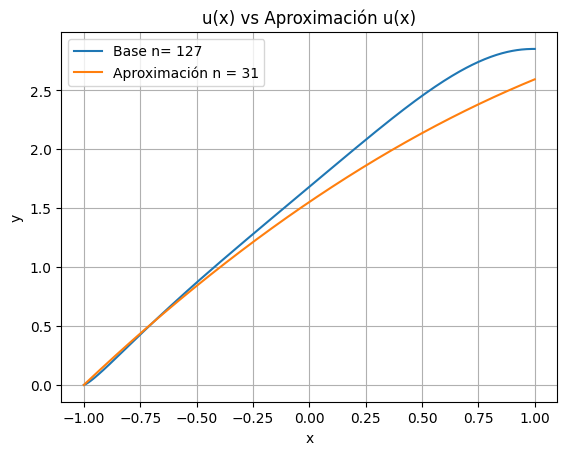

In [ ]:

plt.figure(1)
plt.plot(x,uxBase) # Caso base
plt.plot(x,ux) # caso comparativo
plt.title('u(x) vs Aproximación u(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(('Base n= 127','Aproximación n = 31'))
plt.grid(True)


In [ ]:
def error(uxBase, ux):
  error = np.zeros(len(ux))
  for elemento in range(len(ux)):
    error[elemento] = np.abs((ux[elemento]-uxBase[elemento]))/np.abs(uxBase[elemento])
  epsilon  = sum(error)/len(ux)
  return epsilon

def errorabsoluto(uxBase, ux):
  error = np.zeros(len(ux))
  for elemento in range(len(ux)):
    error[elemento] = np.abs((ux[elemento]-uxBase[elemento]))
  return error


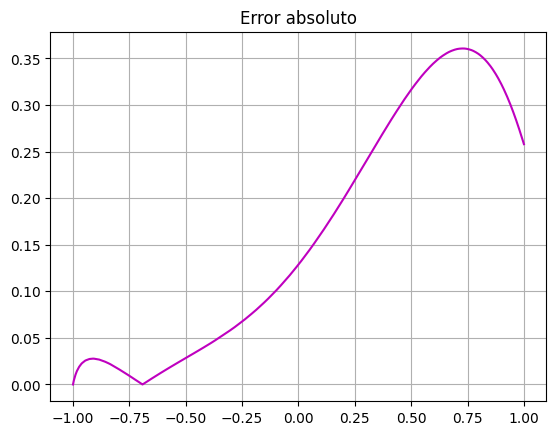

In [ ]:

plt.figure(3)
plt.plot(x,errorabsoluto(uxBase, ux),"m")
plt.title("Error absoluto")
plt.grid(True)

In [ ]:
print(error(uxBase, ux))

0.22756189293515275


In [ ]:
p = np.zeros(4)
p[0]= 3
p[1]= 7
p[2]= 15
p[3]= 31
errores = np.zeros(4)
errores[0] = 0.22756189293515275
errores[1] = 0.09059574124000591
errores[2] = 0.024361979054105764
errores[3] = 0.0059947907643494


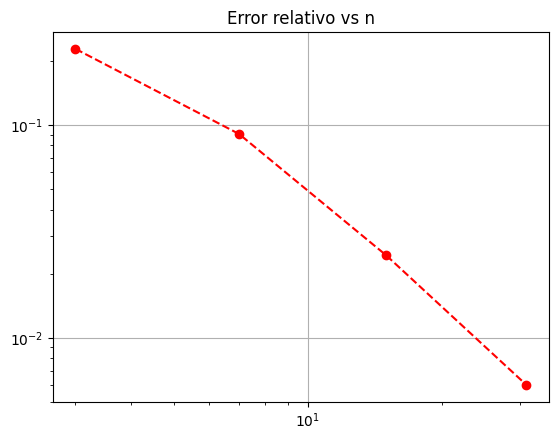

In [ ]:
plt.figure(4)
plt.loglog(p,errores,'--or')
plt.title("Error relativo vs n")
plt.grid(True)

In [ ]:
m = np.abs((errores[3]- errores[0])/p[3]-p[0])
print(m)

3.0071473258764776


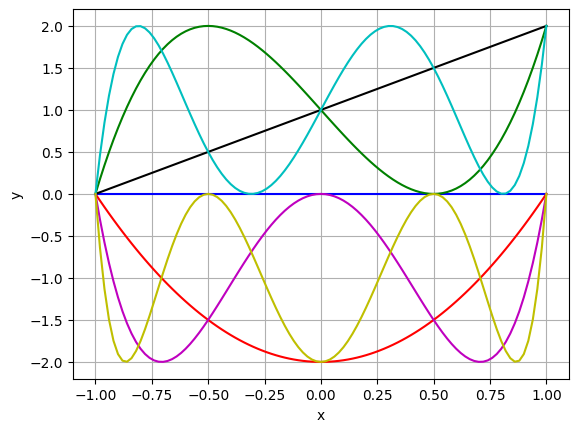

In [ ]:
# GRAFICAMOS LOS POLINOMIOS

xx=np.linspace(-1,1,101)
yy=polinomioT_gorro(xx,7)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)

#print(yy)
plt.plot(xx,yy[:,0],'-b',xx,yy[:,1],'-k',xx,yy[:,2],'-r',xx,yy[:,3],'-g', xx,yy[:,4],'-m', xx,yy[:,5],'-c', xx,yy[:,6],'-y')